![](https://miro.medium.com/max/691/0*xXUYOs5MWWenxoNz)

# CNN для классификации изображений в PyTorch

## Общее о сверточных нейронных сетях в PyTorch  

Полносвязные нейронные сети могут выступать в качестве средства для решения задачи классификации изображений, однако на данный момент доминирующей архитектурой для решения этой задачи являются **сверточные нейронные сети (CNN)**

Классическая сверточная нейронная сеть для классификации изображений состоит из следующих компонентов:
* сверточный слой
* пулинговый слой (или слой субдискретизации)
* слой дропаута (или прореживания)
* блок линейных слоев

Сверточный слой реализует операцию свертки. Она состоит в следующем: на вход слою подается изображение (исходное или уже обработанное), каждый фрагмент каждого канала изображения умножается на ядро свертки поэлементно, результаты по фрагменту суммируются и определяются в позицию, аналогичную таковой у исходного фрагмента. Таким образом формируется карта признаков   

![pic](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_17A-ConvolutionalNeuralNetworks-WHITEBG.png)  

Пулинговый слой (или слой субдискретизации) уплотняет поступающие на него карты признаков, при этом группы пикселей (обычно размером 2х2) "схлопываются" путем нелинейного преобразования, обычно таким преобразованием является максимизация  

![](https://miro.medium.com/max/847/1*FHPUtGrVP6fRmVHDn3A7Rw.png)  

Слой дропаута обнуляет в процессе обучения некоторый случайный набор параметров сети.  Выяснено, что применение этого слоя положительно влияет на склонность сверточной нейросети к обобщению данных

![](https://miro.medium.com/max/1838/1*iWQzxhVlvadk6VAJjsgXgg.png)

Сверточные нейронные сети в PyTorch строятся по аналогии с полносвязными, но с некоторыми отличиями  
В первую очередь, для построения сверточных нейронных сетей в PyTorch применяют модуль `nn.Sequential()` для построения цепочки слоев  

В PyTorch реализовано все необходимое для построения сверточных нейронных сетей.
Их можно представить в виде стека последовательно идущих друг за другом сверточных слоев и слоев субдискретизации (пулинга) с полносвязной сетью в конце

Сверточный слой (в двумерном случае) представлен классом `nn.Conv2D`  
Перечислим основные аргументы:
* `in_features` -- количество входных каналов изображения
* `out_features` -- количество каналов, создаваемых сверточным слоем
* `kernel_size` -- размер ядра свертки
* `stride` -- шаг свертки (по умолчанию 1
* `padding` -- определяет заполнение нулями (по умолчанию 0)

Слой maxpooling (в двумерном случае) представлен классом `nn.MaxPool2D`  
Основные аргументы:
* `kernel_size` -- размер окна пулинга
* `stride` -- шаг окна (по умолчанию равен kernel_size  

Также существуют вариации слоя пулинга, например, `nn.AvgPool`, `nn.AdaptiveMaxPool`, `nn.AdaptiveAvgPool`

Слой дропаута в PyTorch представлен классом `nn.Dropout`, который принимает единственный аргумент `p` -- долю входного тензора, который будет подвержен обнулению

## Построение и обучение простой сверточной нейронной сети на PyTorch

Построим для решения задачи классификации изображений одежды из датасета Fashion-MNIST сверточную нейронную сеть

In [5]:
# необходимые импорты
import torch
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# создаем объект tranfrorm для трансформации изображений
transform = transforms.Compose([
          transforms.ToTensor(),
])

# загрузка тренировочного набора данных Fashion-MNIST
train_data = dataset.FashionMNIST(r"/content/Fashion-MNIST",
                                  train=True,
                                  download=True,
                                  transform=transform,
                                  )

# загрузка тестового набора данных Fashion-MNIST
test_data = dataset.FashionMNIST(r"/content/Fashion-MNIST",
                                 train=False,
                                 download=True,
                                 transform=transform
                                 )

image, target = next(iter(train_data))
print(image.shape)

torch.Size([1, 28, 28])


In [2]:
# создание загрузчика для тренировочного набора данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# создание загрузчика для тестового набора данных
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [18]:
# построение сверточной нейронной сети на PyTorch

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # стек сверточных слоев
        self.conv_layers = nn.Sequential(
            # здесь определяются сверточные слои
            # можно явно вычислить размер выходной карты признаков каждого
            # сверточного слоя по следующей формуле:
            # [(shape + 2 * padding - kernel_size) / stride] + 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28)
            nn.ReLU(),
            # после первого сверточного слоя размер выходной карты признаков равен:
            # [(28 + 2 * 1 - 3) / 1] + 1 = 28.
            nn.MaxPool2d(kernel_size=2),
            # при прохождении слоя MaxPooling с размером окна 2
            # карты признаков сжимаются вдвое
            # 28 / 2 = 14
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # после второго сверточного слоя размер выходной карты признаков равен:
            #[(14 + 2 * 1 - 3) / 1] + 1 = 14
            nn.MaxPool2d(kernel_size=2),
            # после второго слоя MaxPooling2D выходные карты признаков имеют размерность
            # 14 / 2 = 7

	        # Третий сверточный слой
	        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=1, stride=1),
	        nn.ReLU(),
	        # Слой максимального пулинга
	        #[(7 + 2 * 1 - 2) / 1] + 1 = 8
	        nn.MaxPool2d(kernel_size=2)
            # 8 / 2 = 4


        )

        # стек полносвязных слоев
        self.linear_layers = nn.Sequential(
	        # Размер входа в первый линейный слой нужно обновить
	        nn.Linear(in_features=32 * 4 * 4, out_features=64),
	        nn.ReLU(),
	        nn.Dropout(0.2),
	        nn.Linear(in_features=64, out_features=10)
        )


    # определение метода для прямого распространения сигналов по сети
    def forward(self, x):
        x = self.conv_layers(x)
        # перед отправкой в блок полносвязных слоев признаки необходимо сделать одномерными
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# вывод структуры модели
cnn = CNN()
print(cnn)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [25]:
# определим функцию, которая будет вычислять точность модели на итерации
def calculate_accuracy(y_pred, y):

    # находим количество верных совпадений лейбла и выходного класса по каждому примеру в батче
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()

    # посчитаем точность, которая равна отношению количества верных совпадений к общему числу примеров в батче
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
# функция, отвечающая за обучение сети на одной эпохе
def train(model, dataloader, optimizer, loss_function, device):
    # определим значения точности и потерь на старте эпохи
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим тренировки
    model.train()

    # для каждого батча в даталоадере
    for (images, labels) in dataloader:

        # отправляем изображения и метки на устройство
        images = images.to(device)
        labels = labels.to(device)

        # обнуляем градиенты
        optimizer.zero_grad()

        # вычислим выходы сети на данном батче
        predicts = model(images)

        # вычислим величину потерь на данном батче
        loss    = loss_function(predicts, labels)

        # вычислим точность на данном батче
        acc     = calculate_accuracy(predicts, labels)

        # вычислим значения градиентов на батче
        loss.backward()

        # корректируем веса
        optimizer.step()

        # прибавим значения потерь и точности на батче
        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)


In [23]:
# функция, отвечающая за проверку модели на одной эпохе
def evaluate(model, dataloader, loss_function, device):

    # определим начальные величины потерь и точности
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим валидации
    model.eval()

    # указываем, что градиенты вычислять не нужно
    with torch.no_grad():

        # для каждого батча в даталоадере
        for images, labels in dataloader:

            # переносим изображения и лейблы на устройство
            images = images.to(device)
            labels = labels.to(device)

            # вычислим выходы сети на батче
            predicts = model(images)

            # вычислим величину потерь на батче
            loss = loss_function(predicts, labels)

            # вычислим точность на батче
            acc  = calculate_accuracy(predicts, labels)


            # прибавим значения потерь и точности на батче к общему
            epoch_loss += loss.item()
            epoch_acc  += acc.item()


    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)





In [19]:
# определим функцию оптимизации
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# определим функцию потерь
loss_function = nn.CrossEntropyLoss()

# определим устройство, на котором будет идти обучение
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

# перемещение модели на устройство
cnn.to(device)

cuda


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# обучение сверточной сети на наборе данных Fashion-MNIST
epochs = 10

# на каждой эпохе
for epoch in range(epochs):
    # вычисляем точность и потерю на тренировочном наборе
    train_loss, train_acc = train(cnn, train_loader, optimizer, loss_function, device)

    # вычисляем точность и потерю на тестовом наборе
    test_loss, test_acc   = evaluate(cnn, test_loader, loss_function, device)

    # выводим информацию о состоянии обучения в консоль
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')



Epoch: 01
	Train Loss: 0.677 | Train Acc: 74.87%
	 Val. Loss: 0.479 |  Val. Acc: 82.42%
Epoch: 02
	Train Loss: 0.451 | Train Acc: 83.66%
	 Val. Loss: 0.405 |  Val. Acc: 84.79%
Epoch: 03
	Train Loss: 0.395 | Train Acc: 85.59%
	 Val. Loss: 0.358 |  Val. Acc: 86.70%
Epoch: 04
	Train Loss: 0.362 | Train Acc: 86.85%
	 Val. Loss: 0.342 |  Val. Acc: 87.24%
Epoch: 05
	Train Loss: 0.339 | Train Acc: 87.69%
	 Val. Loss: 0.311 |  Val. Acc: 88.44%
Epoch: 06
	Train Loss: 0.317 | Train Acc: 88.42%
	 Val. Loss: 0.318 |  Val. Acc: 88.51%
Epoch: 07
	Train Loss: 0.300 | Train Acc: 89.16%
	 Val. Loss: 0.309 |  Val. Acc: 88.63%
Epoch: 08
	Train Loss: 0.289 | Train Acc: 89.42%
	 Val. Loss: 0.297 |  Val. Acc: 89.50%
Epoch: 09
	Train Loss: 0.280 | Train Acc: 89.74%
	 Val. Loss: 0.283 |  Val. Acc: 89.69%
Epoch: 10
	Train Loss: 0.269 | Train Acc: 90.12%
	 Val. Loss: 0.289 |  Val. Acc: 89.23%


In [13]:
# сохраним обученную сверточную сеть в PTH-файл
torch.save(cnn.state_dict(), "simple_cnn.pth")

tensor([[  6.2335, -11.4081,  -1.4457,  -2.3084,  -9.3185, -12.8160,   2.8693,
         -20.7942,  -4.2322, -16.5941]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Предсказание:  T-shirt/top
Метка: T-shirt/top


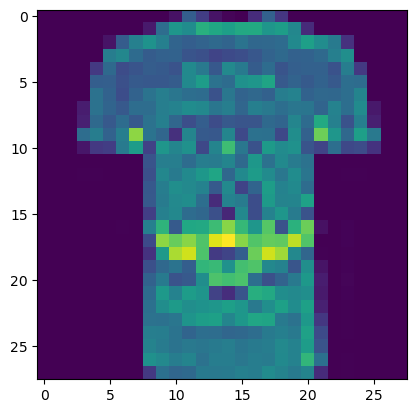

In [14]:
# использование обученной сверточной нейронной сети для классификаций изображений одежды

import random
import matplotlib.pyplot as plt

# список классов
labels = train_data.classes

# возьмем рандомную картинку и метку из тестового набора
idx = random.randint(0, len(test_data) - 1)
image, label = test_data[idx]

# переместим картинку и метку на устройство
image = image.to(device)
label = torch.tensor(label).to(device)

# добавим к картинке размерность батча
image = image.unsqueeze(0)

# формируем предсказания
predictions = cnn(image)
prediction = predictions.argmax()
print(predictions)

# выводим результат
print("Предсказание: ", labels[prediction])
print("Метка:", labels[label])

# выводим картинку
image_array = image.squeeze().cpu().detach().numpy()
plt.imshow(image_array)
plt.show()

## История CNN. Использование предобученных сверточных нейронных сетей для классификации изображений из torchvision.models  

Модели сверточных нейронных сетей существуют уже несколько десятилетий (к примеру, сеть LeNet, одна из первых сверточных архитектур, использовалась еще в 1990-х годах)  

Повсеместное их использование для решения задач компьютерного зрения началось после 2010 года, когда, во-первых, высокопроизводительные GPU стали более доступными и, во-вторых, был подстегнут очередной всплеск интереса к нейронным сетям  

Перечислим основные архитектуры CNN, которые оставили след в истории глубокого обучения  
* **AlexNet** -- сверточная архитектура, в каком-то смысле стала отправной точкой для всплекса интереса к CNN. Эта архитектура вобрала в себя все то, что ныне используется повсеместно для построения CNN: слои MaxPool и Dropout, функция активации ReLU. Это была одной из первых архитектур, продемонстрировавших эффективность обучения многослойных неросетей на GPU. Также она является победителем 2012 года в конкурсе по классификации изображений ImageNet с ошибкой в 15.3%  

![](https://www.mdpi.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png)

* **Inception/GoogLeNet** -- сверточная архитектура, являющаяся победителем конкурса ImageNet в 2014 году. Она является результатом устранения ошибок архитектуры AlexNet. Основное новвоведение -- модуль Inception. Он представляет собой серию разноразмерных сверток, результаты которых соединяются воедино на выходе. Исходная архитектура GoogLeNet состоит из 9 таких модулей. Она обеспечивала производительность с ошибкой 6.67%  
* **VGG** -- семйство сверточных архитектур, занявших второе место на конкурсе ImageNet. В отличие от GoogLeNet, она более проста, и представляет собой простой стек сверточных слоев. Тем не менее, в различных конфигурациях она дает на наборе данных ImageNet величину ошибки, сравнимую с GoogLeNet (около 8%).  Недостатком архитектуры VGG является то, что конечные полносвязные слои очень сильно "раздувают" сеть. Для сравнения: GoogLeNet имеет 7 миллионов параметров, когда как сети VGG могут иметь вплоть до 140 миллионов параметров.  Ее достоинством же является простота конструкции, благодаря которой она все еще остается популярной  

![](https://miro.medium.com/max/2800/0*rbWRzjKvoGt9W3Mf.png)

* **ResNet** -- семейство сверточных архитектур от Microsoft, которые выиграли конкурс ImageNet 2015, достигнув показателя ошибки классификации всего в 4.49% (вариант ResNet-152), что лучше возможностей человека. Семейство ResNet предлагало усовершенствованный подход к уплотнению слоев по сравнению с Inception, плюсом добавлялась связь от начала блока сверток непосредственно е концу. Это позволяет сигналу проходить более "глубоко" по сети, чем это возможно в VGG, при этом она остается легковесной.  

![](https://www.researchgate.net/publication/322621180/figure/fig2/AS:584852684410885@1516451154473/The-representation-of-model-architecture-image-for-ResNet-152-VGG-19-and-two-layered.png)

* **Xception** -- сверточная архитектура, основанная на Inception и представленная в 2016 году Француа Шолле, основным нововведением которой являются так называемые операции  depthwise separable convolutions. Они сворачивают одновременно все каналы входного тензора разными свертками, тем самым уменьшая количество параметров сети на выходе при сохранении точности  

![](https://www.machinelearningmastery.ru/img/0-42382-890398.png)  

* **MobileNet** -- сверточная архитектура, представленная в 2017 году, отчасти опирающаяся на идеи архитектуры Xception и нацеленная на еще большую оптимизацию работы. Основной ее особенностью является отсутствие max-pooling слоев, они заменены свертками с параметром stride, равным 2. Архитектурно MobileNet состоит из одного обычного сверточного слоя 3х3 и 13-ти блоков, структура которых показана ниже (блок справа).  За счет этого удается еще существеннее сократить колчество параметров (4M у MobileNetV1 против 22M у Xception и 138М у VGG16), при этом точность такой сети увеличивается  

![](https://habrastorage.org/r/w1560/webt/rd/0r/jl/rd0rjltrp96j3i_dyhuolbzhyig.png)  


* **EfficientNet** — класс новых моделей, представленный в 2019 году, который получился из изучения масштабирования (скейлинг, scaling) моделей и балансирования между собой глубины и ширины (количества каналов) сети, а также разрешения изображений в сети. Здесь предлагается метод так называемого составного масштабирования, который равномерно масштабирует глубину, ширину и разрешение с фиксированными пропорциями между ними

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.45.54_PM.png)

* **NASNet** -- сверточная архитектура, представленная Google в конце 2019 года, отличающаяся тем, что она, по сути, является плодом системы на основе ИИ под названием Google AutoML. Идея заключалась в поиске наилучшей комбинации архитектуры в фиксированном пространстве поиска, которое включает в себя размеры фильтров, количество выходных каналов, stride и т. д. NASNet показала лучшую точность в конкурсе ImageNet (error rate 2.40%), но с вычислительной точки зрения она является очень затратной  

![](https://miro.medium.com/max/925/1*9uB72g9ixLvnSJxNW2f1ng.png)






Многие из вышеперечисленных моделей представлены в PyTorch "из коробки" в модуле `torchvision.models`  

In [3]:
import torchvision.models as models

# получим для начала модель AlexNet
alexnet = models.AlexNet(num_classes=10)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
# ...а затем взглянем на VGG16
vgg16 = models.vgg16()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# ...и, наконец, на ResNet152
resnet152 = models.resnet152()
print(resnet152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Многие из вышеперечисленных моделей доступны с предварительно обученными весовыми параметрами (например, на ImageNet). что открывает широкие возможности для их использования  

Например, их можно сразу использовать по прямому назначению, т. е. использовать для классификации изображений  

In [15]:
# поджключим Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from PIL import Image

# возьмем для примера предобученную на наборе данных ImageNet модель ResNet152
resnet50 = models.resnet50(pretrained=True)

# создадим новый объект transform
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# откроем пример изображения, которого необходимо классифицировать
image = Image.open("/content/1.jpg")
image = transform(image)
image = image.unsqueeze(0)

# переводим модель в режим теста и формируем предсказания
resnet50.eval()
preds = resnet50(image)
pred = preds.argmax()
print(pred)



FileNotFoundError: [Errno 2] No such file or directory: '/content/1.jpg'

In [17]:
import json

imagenet_classes_file = "/content/drive/MyDrive/trash/imagenet_class_index.json"
with open(imagenet_classes_file) as f:
    labels = json.load(f)

# название предсказанного класса
print(labels[str(int(pred))])


NameError: ignored

## Перенос обучения сверточных нейронных сетей на PyTorch

Также с помощью предобученнных моделей на PyTorch можно выполнять такую высокоэффективную методику, как **перенос обучения**  

Она заключается в использовании предобученных весов для обучения модели на собственном наборе данных  

Это оправдано тем, что, например, архитектура, обученная на ImageNet, уже очень много знает об изображениях, и в этом случае обучение на собственном наборе данных потребует меньше времени и меньше данных  

Попробуем запустить обучение модели ResNet50 на собственном небольшом наборе данных для классификации кошек и собак

In [18]:
# распакуем архив с датасетом из Google Drive
!unzip /content/drive/MyDrive/trash/Dogs_vs_Cats.zip -d /content/dogs_vs_cats

Archive:  /content/drive/MyDrive/trash/Dogs_vs_Cats.zip
   creating: /content/dogs_vs_cats/Dogs vs Cats/
   creating: /content/dogs_vs_cats/Dogs vs Cats/test/
   creating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1500.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1501.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1502.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1503.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1504.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1505.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1506.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1507.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1508.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test/cats/cat.1509.jpg  
  inflating: /content/dogs_vs_cats/Dogs vs Cats/test

In [13]:
# определим пути к тренировочным и тестовым изображениям
train_path = r"Dogs vs Cats/train"
test_path  = r"Dogs vs Cats/test"

# создаем объекты tranfrorm для трансформации изображений
transform_train_new = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
])

transform_test_new = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
])

# создадим объекты ImageFolder для создания загрузчика
train_data = dataset.ImageFolder(train_path, transform_train_new)
test_data = dataset.ImageFolder(test_path, transform_test_new)

print(type(train_data))
print(type(test_data))

print(train_data.classes)
print(test_data.classes)

# создадим загрузчики на основе кастомного датасета
train_loader_1 = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader_1  = DataLoader(test_data, batch_size=16, shuffle=True)

<class 'torchvision.datasets.folder.ImageFolder'>
<class 'torchvision.datasets.folder.ImageFolder'>
['cats', 'dogs']
['cats', 'dogs']


Предобученная модель ResNet50 уже содержит в себе много информации для распознавания и классификации изображений. Поэтому вместо переобучения можно немного изменить ее архитектуру, подстроив под текущий набор данных: заменить блок классификации

В этом случае будет происходить **заморозка** всех слоев и **обучение** нового блока классификации

In [20]:
# инициализируем предобученную модель ResNet50
pretrained_resnet50 = models.resnet50(pretrained=True)

# замораживаем слои, используя метод requires_grad()
# в этом случае не вычисляются градиенты для слоев
# сделать это надо для всех параметеров сети
for name, param in pretrained_resnet50.named_parameters():
    param.requires_grad = False


# к различным блокам модели в PyTorch легко получить доступ
# заменим блок классификатора на свой, подходящий для решения
# задачи классификации кошек и собак
pretrained_resnet50.fc = nn.Sequential(
    nn.Linear(pretrained_resnet50.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)

# перенесем модель на устройство
pretrained_resnet50.to(device)

# выведем модель
print(pretrained_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
# попробуем обучить!

epochs = 10
optimizer = optim.Adam(pretrained_resnet50.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


for epoch in range(epochs):

    train_loss, train_acc = train(pretrained_resnet50, train_loader_1, optimizer, loss_function, device)

    test_loss, test_acc   = evaluate(pretrained_resnet50, test_loader_1, loss_function, device)

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')

Epoch: 01
	Train Loss: 0.676 | Train Acc: 69.32%
	 Val. Loss: 0.107 |  Val. Acc: 95.83%
Epoch: 02
	Train Loss: 0.461 | Train Acc: 82.39%
	 Val. Loss: 0.265 |  Val. Acc: 87.50%
Epoch: 03
	Train Loss: 0.221 | Train Acc: 89.77%
	 Val. Loss: 0.170 |  Val. Acc: 89.58%
Epoch: 04
	Train Loss: 0.139 | Train Acc: 95.45%
	 Val. Loss: 0.085 |  Val. Acc: 97.92%
Epoch: 05
	Train Loss: 0.083 | Train Acc: 97.16%
	 Val. Loss: 0.064 |  Val. Acc: 95.83%
Epoch: 06
	Train Loss: 0.173 | Train Acc: 91.48%
	 Val. Loss: 0.070 |  Val. Acc: 97.92%
Epoch: 07
	Train Loss: 0.099 | Train Acc: 95.45%
	 Val. Loss: 0.064 |  Val. Acc: 97.92%
Epoch: 08
	Train Loss: 0.048 | Train Acc: 98.30%
	 Val. Loss: 0.074 |  Val. Acc: 95.83%
Epoch: 09
	Train Loss: 0.054 | Train Acc: 98.86%
	 Val. Loss: 0.053 |  Val. Acc: 97.92%
Epoch: 10
	Train Loss: 0.094 | Train Acc: 95.45%
	 Val. Loss: 0.195 |  Val. Acc: 91.67%


In [22]:
# сохранение модели в PTH
torch.save(pretrained_resnet50.state_dict(), "resnet50_pretrained.pth")

In [23]:
# выгрузим из PTH-файла обученную ResNet-50 и загрузим ее словарь состояния
resnet50_state_dict = torch.load("resnet50_pretrained.pth")
resnet50 = models.resnet50(pretrained=False)

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)

resnet50.load_state_dict(resnet50_state_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [24]:
# применим обученную на кошках и собаках ResNet-50
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# откроем пример изображения, которого необходимо классифицировать
image = Image.open("/content/dogs_vs_cats/Dogs vs Cats/test/dogs/dog.1500.jpg")
image = transform(image)
image = image.unsqueeze(0)

# переводим модель в режим теста и формируем предсказания
resnet50.eval()
preds = resnet50(image)
pred = preds.argmax()
labels = test_data.classes
print(labels[pred])

dogs


Существуют методики для улучшения показателей точности модели: аугментация данных, применение подхода дифференцированного обучения и т. д.

## Конвертация сверточной нейронной сети в ONNX

**ONNX** (Open Neural Network Exchange) -- открытый формат хранения нейросетевых моделей.

С помощью ONNX разработчики могут обмениваться моделями между различными инструментами и выбирать наилучшую комбинацию этих инструментов. ONNX разрабатывается и поддерживается совместно компаниями Microsoft, Facebook, Amazon и другими партнерами как проект с открытым исходным кодом

Перевод моделей из PTH в ONNX имеется в PyTorch из коробки  
Для этого нужно использовать модуль `torch.onnx`  

In [30]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.3 MB/s eta 0:00:00


In [27]:
# импортируем torch.onnx
import torch.onnx

# сформируем вход модели
x = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)

# сгенерируем выходы предобученной модели (например, предобученной ResNet50)
outs = pretrained_resnet50(x)

# экспортируем модель в onnx
torch.onnx.export(pretrained_resnet50, x, "resnet50_pretrained.onnx")

In [ ]:
# установим модули onnx и onnxruntime
!pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 26.6 MB/s 
     |████████████████████████████████| 4.5 MB 47.1 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 


In [28]:
# теперь мы можем проверить ONNX-модель на работоспособность
# но перед этим проверим ее структуру через модуль onnx
import onnx

onnx_model = onnx.load("resnet50_pretrained.onnx")
onnx.checker.check_model(onnx_model)

In [31]:
# убедимся, что выходы PTH-модели и ONNX-модели совпадают

import onnxruntime
import numpy as np

# инициализируем сессию  ONNXRuntime
ort_session = onnxruntime.InferenceSession("resnet50_pretrained.onnx")

# определим функцию перевода тензора в numpy-массив
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# определим входы и выходы
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# сравним результаты
np.testing.assert_allclose(to_numpy(outs[0]), ort_outs[0][0], rtol=1e-03, atol=1e-05)
print("Все в порядке")

Все в порядке


Истинный класс: cats
Предсказанный класс: cats


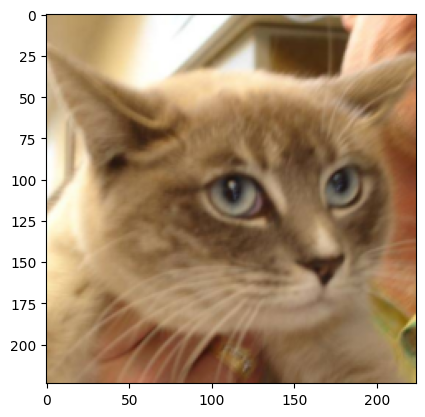

In [32]:
# используем ONNX-модель предобученной ResNet-50 по прямому назначению
import matplotlib.pyplot as plt

labels = test_data.classes

# возьмем пример из тестового набора
image, label = test_data[12]
label = torch.tensor(label)

# поместим его на девайс и добавим рахмерность батча
image = image.to(device)
image = image.unsqueeze(0)
label = label.to(device)

# инициализируем входы и выходы ONNX-модели
inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
outs = ort_session.run(None, inputs)

# формируем предсказания
prediction = outs[0].argmax()

# для "отбрасывания" размерности батча вызываем функцию squeeze()
image_squezze = image.squeeze()

# перевод изображения в NumPy-массив для отображения на графике
image_numpy = image_squezze.cpu().numpy()

# вывод изображения, метки класса и предсказания
print(f"Истинный класс: {labels[prediction]}")
print(f"Предсказанный класс: {labels[label]}")

plt.imshow(image_numpy.transpose(1, 2, 0))
plt.show()

# Задания

1. Добавьте в исходную простую CNN:
  * 1 сверточный слой (3-й по счету), параметры которого имеют следующий вид:   in_channels=16, out_channels=32, kernel_size=2, padding=1, stride=1  
  * следом за ним 1 слой максимального пулинга с kernel_size=2  

  Проведите итерацию обучения измененной модели на Fashion-MNIST. Увеличилась   или уменьшилась точность по сравнению с исходной моделью? Сохраните измененную модель в PTH-файле. Загрузите сохраненную модель и выполните классификацию на любом примере из Fashion-MNIST.

2. Проведите итерацию обучения модели ResNet-152 на датасете с собаками и кошками. Увеличилась или уменьшилась точность в сравнении с ResNet-50? Сохраните обученную модель ResNet-152 в PTH-файле. Загрузите модель из PTH-файла и выполните классификацию на любом примере из датасета с собаками и кошками

3. Сконвертируйте модель ResNet-152, полученную в п. 3, в формат ONNX. Выполните классификацию с помощью onnxruntime на любой картинке из датасета с кошками и собаками.


Результатом данной работы должен быть архив с 3 файлами:
* Сохраненная в PTH простая CNN из п. 1
* Сохраненная в PTH модель ResNet-152 из п. 2
* Сохраненная в ONNX модель ResNet-152 из п. 3

# Задание 1

* Точность осталась примерно такой же

# Задание 2

In [29]:
# инициализируем предобученную модель ResNet50
pretrained_resnet152 = models.resnet152(pretrained=True)

# замораживаем слои, используя метод requires_grad()
# в этом случае не вычисляются градиенты для слоев
# сделать это надо для всех параметеров сети
for name, param in pretrained_resnet152.named_parameters():
	param.requires_grad = False


# к различным блокам модели в PyTorch легко получить доступ
# заменим блок классификатора на свой, подходящий для решения
# задачи классификации кошек и собак
pretrained_resnet152.fc = nn.Sequential(
	nn.Linear(pretrained_resnet152.fc.in_features, 500),
	nn.ReLU(),
	nn.Dropout(),
	nn.Linear(500, 2)
)

# перенесем модель на устройство
pretrained_resnet152.to(device)

# выведем модель
print(pretrained_resnet152)

C:\Users\morph\anaconda3\envs\workspace\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\morph\anaconda3\envs\workspace\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
epochs = 10
optimizer = optim.Adam(pretrained_resnet152.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


for epoch in range(epochs):

	train_loss, train_acc = train(pretrained_resnet152, train_loader_1, optimizer, loss_function, device)

	test_loss, test_acc   = evaluate(pretrained_resnet152, test_loader_1, loss_function, device)

	print(f'Epoch: {epoch + 1:02}')
	print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
	print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')

Epoch: 01
	Train Loss: 0.494 | Train Acc: 75.57%
	 Val. Loss: 0.293 |  Val. Acc: 83.33%
Epoch: 02
	Train Loss: 0.340 | Train Acc: 85.23%
	 Val. Loss: 0.077 |  Val. Acc: 95.83%
Epoch: 03
	Train Loss: 0.148 | Train Acc: 93.75%
	 Val. Loss: 0.053 |  Val. Acc: 97.92%
Epoch: 04
	Train Loss: 0.100 | Train Acc: 97.16%
	 Val. Loss: 0.328 |  Val. Acc: 87.50%
Epoch: 05
	Train Loss: 0.174 | Train Acc: 94.32%
	 Val. Loss: 0.087 |  Val. Acc: 97.92%
Epoch: 06
	Train Loss: 0.122 | Train Acc: 96.02%
	 Val. Loss: 0.079 |  Val. Acc: 97.92%
Epoch: 07
	Train Loss: 0.174 | Train Acc: 94.32%
	 Val. Loss: 0.082 |  Val. Acc: 97.92%
Epoch: 08
	Train Loss: 0.066 | Train Acc: 98.30%
	 Val. Loss: 0.270 |  Val. Acc: 91.67%
Epoch: 09
	Train Loss: 0.124 | Train Acc: 94.89%
	 Val. Loss: 0.286 |  Val. Acc: 91.67%
Epoch: 10
	Train Loss: 0.100 | Train Acc: 97.16%
	 Val. Loss: 0.159 |  Val. Acc: 91.67%


In [31]:
# сохранение модели в PTH
torch.save(pretrained_resnet152.state_dict(), "resnet152_pretrained.pth")

In [33]:
# выгрузим из PTH-файла обученную ResNet-50 и загрузим ее словарь состояния
resnet152_state_dict = torch.load("resnet152_pretrained.pth")
resnet152 = models.resnet152(pretrained=False)

resnet152.fc = nn.Sequential(
	nn.Linear(resnet152.fc.in_features, 500),
	nn.ReLU(),
	nn.Dropout(),
	nn.Linear(500, 2)
)

resnet152.load_state_dict(resnet152_state_dict)

C:\Users\morph\anaconda3\envs\workspace\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\morph\anaconda3\envs\workspace\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [35]:
# применим обученную на кошках и собаках
transform = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# откроем пример изображения, которого необходимо классифицировать
image = Image.open("Dogs vs Cats/test/dogs/dog.1500.jpg")
image = transform(image)
image = image.unsqueeze(0)

# переводим модель в режим теста и формируем предсказания
resnet152.eval()
preds = resnet152(image)
pred = preds.argmax()
labels = test_data.classes
print(labels[pred])

cats


# Задание 3

In [36]:
import torch.onnx

# сформируем вход модели
x = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)

# сгенерируем выходы предобученной модели (например, предобученной ResNet50)
outs = pretrained_resnet50(x)

# экспортируем модель в onnx
torch.onnx.export(pretrained_resnet50, x, "resnet152_pretrained.onnx")

In [37]:
import onnx

onnx_model = onnx.load("resnet152_pretrained.onnx")
onnx.checker.check_model(onnx_model)
# убедимся, что выходы PTH-модели и ONNX-модели совпадают


In [38]:
import onnxruntime
import numpy as np

# инициализируем сессию  ONNXRuntime
ort_session = onnxruntime.InferenceSession("resnet152_pretrained.onnx")


# определим функцию перевода тензора в numpy-массив
def to_numpy(tensor):
	return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# определим входы и выходы
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# сравним результаты
np.testing.assert_allclose(to_numpy(outs[0]), ort_outs[0][0], rtol=1e-03, atol=1e-05)
print("Все в порядке")

Все в порядке


Истинный класс: cats
Предсказанный класс: cats


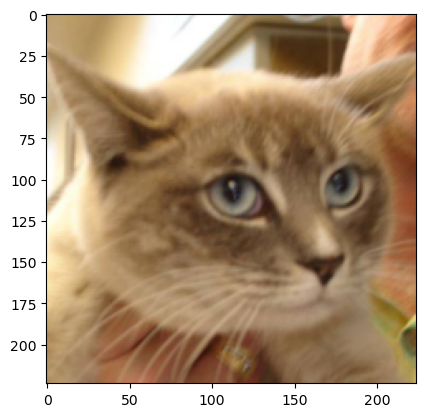

In [39]:
# используем ONNX-модель предобученной ResNet-50 по прямому назначению
import matplotlib.pyplot as plt

labels = test_data.classes

# возьмем пример из тестового набора
image, label = test_data[12]
label = torch.tensor(label)

# поместим его на девайс и добавим рахмерность батча
image = image.to(device)
image = image.unsqueeze(0)
label = label.to(device)

# инициализируем входы и выходы ONNX-модели
inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
outs = ort_session.run(None, inputs)

# формируем предсказания
prediction = outs[0].argmax()

# для "отбрасывания" размерности батча вызываем функцию squeeze()
image_squezze = image.squeeze()

# перевод изображения в NumPy-массив для отображения на графике
image_numpy = image_squezze.cpu().numpy()

# вывод изображения, метки класса и предсказания
print(f"Истинный класс: {labels[prediction]}")
print(f"Предсказанный класс: {labels[label]}")

plt.imshow(image_numpy.transpose(1, 2, 0))
plt.show()